# Demographic clustering of Toulouse
The goal of this project is to get some insight about the town I am living in: Toulouse (FR). 
In the very next future I could be interested in buying or selling an appartment so I would like to have an insight that could help me finding the best location. The example of the introduction of this module will be completed with a dataset that is freely available on insee website (even if it is in French).
## Step 1: Import many helpful libraries
This libraries are both presented in the course or were found on the web to do some manipulation on demographic data.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import shapely
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh
import cartopy
import statsmodels
import sklearn
import geoplot
import folium
import dash
import rasterio
import rasterstats
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans

## Step 2: Download and unzip French Demographic database

In [2]:
os.system("wget -O DATA/Filosofi2015_carreaux_niveau_naturel_csv.zip https://www.insee.fr/fr/statistiques/fichier/4176281/Filosofi2015_carreaux_niveau_naturel_csv.zip")
#os.system("wget -O Filosofi2015_carreaux_200m_shp.zip https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_shp.zip")
print("Data Downloaded")

Data Downloaded


In [3]:
!unzip -o -j DATA/Filosofi2015_carreaux_niveau_naturel_csv.zip -d DATA
 #!unzip -o -j Filosofi2015_carreaux_200m_shp.zip

Archive:  DATA/Filosofi2015_carreaux_niveau_naturel_csv.zip
  inflating: DATA/Filosofi2015_carreaux_niveau_naturel_reg02_csv.7z  
  inflating: DATA/Filosofi2015_carreaux_niveau_naturel_reg04_csv.7z  
  inflating: DATA/Filosofi2015_carreaux_niveau_naturel_metropole_csv.7z  


Toulouse is in metropolitan France so we unzip only the corresponding file.

In [4]:
#!7z e Filosofi2015_carreaux_200m_metropole_shp.7z
!7z e DATA/Filosofi2015_carreaux_niveau_naturel_metropole_csv.7z -oDATA -y


7-Zip 19.00 (x64) : Copyright (c) 1999-2018 Igor Pavlov : 2019-02-21

Scanning the drive for archives:
1 file, 6368936 bytes (6220 KiB)

Extracting archive: DATA\Filosofi2015_carreaux_niveau_naturel_metropole_csv.7z
--
Path = DATA\Filosofi2015_carreaux_niveau_naturel_metropole_csv.7z
Type = 7z
Physical Size = 6368936
Headers Size = 202
Method = LZMA:25
Solid = -
Blocks = 1

Everything is Ok

Size:       26147825
Compressed: 6368936


 ## Step 3: Read csv file in a dataframe 
 

In [5]:
#import the dataframe and give a look to it
df_demographics = pd.read_csv('DATA/Filosofi2015_carreaux_niveau_naturel_metropole.csv')

A complete documentation containing details about this data attributes can be found here:
https://www.insee.fr/fr/statistiques/4176290?sommaire=4176305

Of course it is in french so I will make some translations here.
Each row of this dataset contains some demographic data relative to a square on the french territory. 


In [6]:
df_demographics.head()

Id_carr_n    Ind   Men  Men_pauv  Men_1ind  Men_5ind  \
0  CRS3035RES1000mN2034000E4252000  144.0  57.0       9.0      17.0       4.9   
1  CRS3035RES1000mN2034000E4253000   45.0  21.0       3.0       6.0       0.0   
2  CRS3035RES1000mN2035000E4252000   81.0  33.8       3.1      11.2       3.1   
3  CRS3035RES1000mN2035000E4253000   46.0  19.9       4.0       7.1       0.9   
4  CRS3035RES1000mN2044000E4253000   91.0  41.9       3.1      18.0       3.0   

   Men_prop  Men_fmp    Ind_snv  Men_surf  ...  Ind_11_17  Ind_18_24  \
0      33.2      5.0  3352210.9    4874.9  ...        9.3        8.1   
1      12.0      3.0   845666.2    1389.0  ...        6.0        2.1   
2      19.1      9.8  1713668.3    2777.1  ...        5.8        6.4   
3      13.1      1.9  1013579.4    1765.9  ...        3.1        3.1   
4      27.9      4.0  2246566.4    3280.0  ...        4.0        3.1   

   Ind_25_39  Ind_40_54  Ind_55_64  Ind_65_79  Ind_80p  Ind_inc  I_pauv  \
0       32.3       23.1       19.7       19.8      5.9      2.1       0   
1       12.0        6.0        3.9        9.0      0.9      1.2       0   
2        9.7       17.6       16.1        9.8      3.1      3.3       0   
3        7.9       13.2        8.0        5.1      1.9      0.9       0   
4       16.9       16.9       14.0       19.1      7.9      0.0       0   

   t_maille  
0      1000  
1      1000  
2      1000  
3      1000  
4      1000  

[5 rows x 31 columns]

Each square is identified by Id_carr_n which contains its bottom left corner and its side length.
for instance RES 1000m will means that the side of the square is 1000 meters this is also reported in the attribute t_maille.
The coordinates are provided in a projected reference system called epsg 3035 as described in the documentation. 
N stands for Nord and and E stands for East, so it means tha instead of providing longitude and latitude data are provided as on a 2D map with x and y positions. 

In [7]:
df_demographics.shape

(142921, 31)

The entries in this dataset are 142921 it is indeed quite big.

## Step 4: Let's extract x and y coordinates from Id_carr_n

**Here the coordinates of the center of the square are computed reading the Id_carr_n and using the square size (t_maille).**

In [8]:
df_demographics['x_coordinate'] = df_demographics.Id_carr_n.str.extract('(N\d\d\d\d\d\d\dE)',expand=False)
df_demographics['x_coordinate'] = df_demographics.x_coordinate.str.extract('(\d\d\d\d\d\d\d)',expand=False)
df_demographics['x_coordinate'] = df_demographics['x_coordinate'].apply(lambda x: int(x))+df_demographics['t_maille']/2
df_demographics['y_coordinate'] = df_demographics.Id_carr_n.str.extract('(E\d\d\d\d\d\d\d)',expand=False)
df_demographics['y_coordinate'] = df_demographics.y_coordinate.str.extract('(\d\d\d\d\d\d\d)',expand=False)
df_demographics['y_coordinate'] = df_demographics['y_coordinate'].apply(lambda x: int(x))+df_demographics['t_maille']/2

In [9]:
df_demographics.head()

Id_carr_n    Ind   Men  Men_pauv  Men_1ind  Men_5ind  \
0  CRS3035RES1000mN2034000E4252000  144.0  57.0       9.0      17.0       4.9   
1  CRS3035RES1000mN2034000E4253000   45.0  21.0       3.0       6.0       0.0   
2  CRS3035RES1000mN2035000E4252000   81.0  33.8       3.1      11.2       3.1   
3  CRS3035RES1000mN2035000E4253000   46.0  19.9       4.0       7.1       0.9   
4  CRS3035RES1000mN2044000E4253000   91.0  41.9       3.1      18.0       3.0   

   Men_prop  Men_fmp    Ind_snv  Men_surf  ...  Ind_25_39  Ind_40_54  \
0      33.2      5.0  3352210.9    4874.9  ...       32.3       23.1   
1      12.0      3.0   845666.2    1389.0  ...       12.0        6.0   
2      19.1      9.8  1713668.3    2777.1  ...        9.7       17.6   
3      13.1      1.9  1013579.4    1765.9  ...        7.9       13.2   
4      27.9      4.0  2246566.4    3280.0  ...       16.9       16.9   

   Ind_55_64  Ind_65_79  Ind_80p  Ind_inc  I_pauv  t_maille  x_coordinate  \
0       19.7       19.8      5.9      2.1       0      1000     2034500.0   
1        3.9        9.0      0.9      1.2       0      1000     2034500.0   
2       16.1        9.8      3.1      3.3       0      1000     2035500.0   
3        8.0        5.1      1.9      0.9       0      1000     2035500.0   
4       14.0       19.1      7.9      0.0       0      1000     2044500.0   

   y_coordinate  
0     4252500.0  
1     4253500.0  
2     4252500.0  
3     4253500.0  
4     4253500.0  

[5 rows x 33 columns]

## Step 5: Let's compute longitude and latitude from each square

**The square coordinates need to be transformed into latitude and longitude. For that we use pyproj library.**

In [10]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:3035')
outProj = Proj(init='epsg:4326')
x1,y1 = -11705274.6374,4826473.6922
x2,y2 = transform(inProj,outProj,x1,y1)
#transform(inProj,outProj,df_demographics['x_coordinate'],df_demographics['y_coordinate'])
df_demographics[['long','lat']]=df_demographics.apply(lambda x: transform(inProj,outProj,x['y_coordinate'],x['x_coordinate']), axis=1, result_type="expand")


In [11]:
df_demographics.head()

Id_carr_n    Ind   Men  Men_pauv  Men_1ind  Men_5ind  \
0  CRS3035RES1000mN2034000E4252000  144.0  57.0       9.0      17.0       4.9   
1  CRS3035RES1000mN2034000E4253000   45.0  21.0       3.0       6.0       0.0   
2  CRS3035RES1000mN2035000E4252000   81.0  33.8       3.1      11.2       3.1   
3  CRS3035RES1000mN2035000E4253000   46.0  19.9       4.0       7.1       0.9   
4  CRS3035RES1000mN2044000E4253000   91.0  41.9       3.1      18.0       3.0   

   Men_prop  Men_fmp    Ind_snv  Men_surf  ...  Ind_55_64  Ind_65_79  Ind_80p  \
0      33.2      5.0  3352210.9    4874.9  ...       19.7       19.8      5.9   
1      12.0      3.0   845666.2    1389.0  ...        3.9        9.0      0.9   
2      19.1      9.8  1713668.3    2777.1  ...       16.1        9.8      3.1   
3      13.1      1.9  1013579.4    1765.9  ...        8.0        5.1      1.9   
4      27.9      4.0  2246566.4    3280.0  ...       14.0       19.1      7.9   

   Ind_inc  I_pauv  t_maille  x_coordinate  y_coordinate      long        lat  
0      2.1       0      1000     2034500.0     4252500.0  9.184071  41.408295  
1      1.2       0      1000     2034500.0     4253500.0  9.195982  41.408392  
2      3.3       0      1000     2035500.0     4252500.0  9.183952  41.417336  
3      0.9       0      1000     2035500.0     4253500.0  9.195865  41.417432  
4      0.0       0      1000     2044500.0     4253500.0  9.194808  41.498790  

[5 rows x 35 columns]

## Step 6: Let's select Tolouse squares

To know longitude and latitude of Toulouse we can use Nominatim as in the class of the cours.


In [12]:
address = 'Toulouse, FR'

geolocator = Nominatim(user_agent="FR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toulouse are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toulouse are 43.6044622, 1.4442469.


we select all the squares at a Latitude/longitude distance lower than 0.1°

In [13]:
selection_size=0.1
lower_corner=[latitude-selection_size, longitude-selection_size]
upper_corner=[latitude+selection_size, longitude+selection_size]
df_demographics=df_demographics.loc[(lower_corner[0]<=df_demographics.lat) & (df_demographics.lat<=upper_corner[0]) & (lower_corner[1]<=df_demographics.long) & (df_demographics.long<=upper_corner[1])]
df_demographics.head()

Id_carr_n     Ind    Men  Men_pauv  Men_1ind  \
4288  CRS3035RES1000mN2305000E3631000   125.0   40.0       2.9       2.9   
4289  CRS3035RES1000mN2305000E3634000  1230.5  521.0      17.9     141.0   
4290  CRS3035RES1000mN2305000E3635000    54.0   23.0       1.0       7.8   
4376  CRS3035RES1000mN2306000E3622000  1463.0  659.0      54.9     214.0   
4377  CRS3035RES1000mN2306000E3623000   614.5  255.0      27.2      70.1   

      Men_5ind  Men_prop  Men_fmp     Ind_snv  Men_surf  ...  Ind_55_64  \
4288       4.0      33.3      2.0   3981311.5    6275.7  ...       15.0   
4289      29.1     388.0     48.9  34788531.4   50434.0  ...      189.0   
4290       0.0      13.0      0.0   1426195.4    2323.8  ...        6.9   
4376      27.0     406.1     61.0  35119333.9   55500.0  ...      151.1   
4377      15.2     171.0     27.2  16022939.6   26761.0  ...       81.1   

      Ind_65_79  Ind_80p  Ind_inc  I_pauv  t_maille  x_coordinate  \
4288       12.9      7.1     12.9       0      1000     2305500.0   
4289      149.9     44.0     51.0       0      1000     2305500.0   
4290        9.3      2.9      0.0       0      1000     2305500.0   
4376      235.0     65.1     19.0       0      1000     2306500.0   
4377       99.3     33.9     18.9       0      1000     2306500.0   

      y_coordinate      long        lat  
4288     3631500.0  1.475173  43.505158  
4289     3634500.0  1.511997  43.508222  
4290     3635500.0  1.524273  43.509240  
4376     3622500.0  1.363387  43.504846  
4377     3623500.0  1.375660  43.505882  

[5 rows x 35 columns]

## Step 7: Let's compute some other metrics

The population counts in each square is tranformed in population density in order to have an homegenized measure.

In [225]:
df_demographics['pop_density'] =df_demographics['Ind']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_0_3'] =df_demographics['Ind_0_3']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_4_5'] =df_demographics['Ind_4_5']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_6_10'] =df_demographics['Ind_6_10']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_11_17'] =df_demographics['Ind_11_17']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_18_24'] =df_demographics['Ind_18_24']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_25_39'] =df_demographics['Ind_25_39']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_40_54'] =df_demographics['Ind_40_54']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_55_64'] =df_demographics['Ind_55_64']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_65_79'] =df_demographics['Ind_65_79']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['pop_density_80p'] =df_demographics['Ind_80p']/(df_demographics['t_maille']**2)*10**6 #[ individuals per squared kilometer]
df_demographics['Poor_density']=df_demographics['Men_pauv']/(df_demographics['t_maille']**2)*10**6
df_demographics['new_log_density']=df_demographics['Log_ap90']/(df_demographics['t_maille']**2)*10**6
df_demographics['Men_av_surface']=df_demographics['Men_surf']/df_demographics['Men']
df_demographics['pop_density_0_17']=df_demographics['pop_density_0_3']+df_demographics['pop_density_4_5']+df_demographics['pop_density_6_10']+df_demographics['pop_density_11_17']
df_demographics['pop_density_18_64']=df_demographics['pop_density_18_24']+df_demographics['pop_density_25_39']+df_demographics['pop_density_40_54']+df_demographics['pop_density_55_64']
df_demographics['pop_density_65p']=df_demographics['pop_density_65_79']+df_demographics['pop_density_80p']
df_demographics['part_0_17']=df_demographics['pop_density_0_17']/df_demographics['pop_density']
df_demographics['part_18_64']=df_demographics['pop_density_18_64']/df_demographics['pop_density']
df_demographics['part_65p']=df_demographics['pop_density_65p']/df_demographics['pop_density']
df_demographics['part_poor']=df_demographics['Men_pauv']/df_demographics['Men']
df_demographics['part_new']=df_demographics['Log_ap90']/df_demographics['Men']
df_clustering_prep=df_demographics[['Id_carr_n','lat','long','pop_density','part_poor','part_new','Men_av_surface']]
df_clustering_prep.head()

Id_carr_n        lat      long  pop_density  \
4288  CRS3035RES1000mN2305000E3631000  43.505158  1.475173        125.0   
4289  CRS3035RES1000mN2305000E3634000  43.508222  1.511997       1230.5   
4290  CRS3035RES1000mN2305000E3635000  43.509240  1.524273         54.0   
4376  CRS3035RES1000mN2306000E3622000  43.504846  1.363387       1463.0   
4377  CRS3035RES1000mN2306000E3623000  43.505882  1.375660        614.5   

      part_poor  part_new  Men_av_surface  
4288   0.072500  0.625000      156.892500  
4289   0.034357  0.587140       96.802303  
4290   0.043478  0.300000      101.034783  
4376   0.083308  0.508346       84.218513  
4377   0.106667  0.231373      104.945098

## Step 8: Let's display population some metrics on a map

The results are shown on a map using folium as in the cours. The color of each marker is in relation with the population density. 

In [241]:
# create map of Toulouse using latitude and longitude values
mapps=[]
for col in df_clustering_prep.drop(['Id_carr_n','lat','long'], 1).columns:
    map_Toulouse = folium.Map(location=[latitude, longitude], zoom_start=11)
    sismic_color = plt.get_cmap('hot')
    norm = mpl.colors.Normalize(vmin=df_demographics[col].min(),vmax=df_demographics[col].max())
    color_list=sismic_color(norm(df_demographics[col]))
    rainbow = [colors.rgb2hex(i) for i in color_list]
    # add markers to map
    for lat, lng, population_size,clr in zip(df_demographics['lat'], df_demographics['long'], df_demographics[col],rainbow):
        label = col+': {}'.format(population_size)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            parse_html=False).add_to(map_Toulouse) 
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>''' +col +'''</b></h3>
             '''
    map_Toulouse.get_root().html.add_child(folium.Element(title_html))
    mapps.append(map_Toulouse)
    

In [242]:
mapps[0]

In [243]:
mapps[1]

In [244]:
mapps[2]

In [245]:
mapps[3]

In [246]:
# set number of clusters
kclusters = 3

df_clustering = df_clustering_prep.drop(['Id_carr_n','lat','long'], 1)
df_clustering=sklearn.preprocessing.scale(df_clustering)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [247]:
# add clustering labels
df_clustering_prep.insert(0, 'Cluster Labels', kmeans.labels_)
df_clustering_prep.insert(0, 'Cluster Names', kmeans.labels_)
df_clustering_prep.head()


Cluster Names  Cluster Labels                        Id_carr_n  \
4288              1               1  CRS3035RES1000mN2305000E3631000   
4289              1               1  CRS3035RES1000mN2305000E3634000   
4290              1               1  CRS3035RES1000mN2305000E3635000   
4376              0               0  CRS3035RES1000mN2306000E3622000   
4377              1               1  CRS3035RES1000mN2306000E3623000   

            lat      long  pop_density  part_poor  part_new  Men_av_surface  
4288  43.505158  1.475173        125.0   0.072500  0.625000      156.892500  
4289  43.508222  1.511997       1230.5   0.034357  0.587140       96.802303  
4290  43.509240  1.524273         54.0   0.043478  0.300000      101.034783  
4376  43.504846  1.363387       1463.0   0.083308  0.508346       84.218513  
4377  43.505882  1.375660        614.5   0.106667  0.231373      104.945098

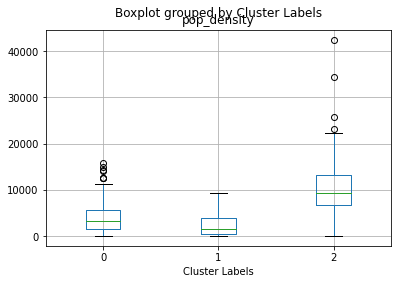

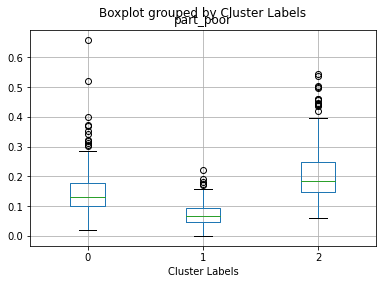

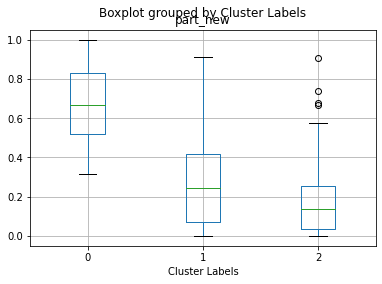

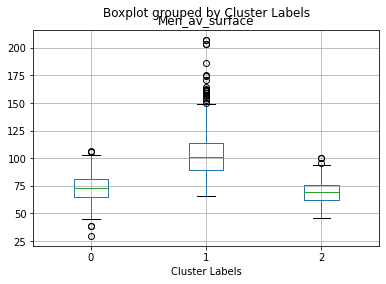

In [248]:
for column in df_clustering_prep.drop(['Id_carr_n','lat','long','Cluster Labels','Cluster Names'], 1).columns:
    boxplot = df_clustering_prep.drop(['Id_carr_n','lat','long'], 1).boxplot(by='Cluster Labels', column=column)

In [249]:
df_clustering_prep.loc[df_clustering_prep['Cluster Labels']==0,df_clustering_prep.columns[4:]].describe()


long   pop_density   part_poor    part_new  Men_av_surface
count  210.000000    210.000000  210.000000  210.000000      210.000000
mean     1.435213   4052.689881    0.150917    0.680926       73.286191
std      0.043676   3292.821599    0.080956    0.185244       13.254832
min      1.345767     24.000000    0.018519    0.316667       29.624113
25%      1.407298   1541.500000    0.101721    0.518158       64.586732
50%      1.431757   3206.250000    0.131011    0.668423       72.868257
75%      1.467444   5743.750000    0.177882    0.831719       80.827779
max      1.543598  15837.500000    0.659574    1.000000      106.991664

In [250]:
df_clustering_prep.loc[df_clustering_prep['Cluster Names']==0,'Cluster Names']='Newer & medium Households, middle pop. density, middle incomes'

C:\Users\simon\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [251]:
df_clustering_prep.loc[df_clustering_prep['Cluster Labels']==1,df_clustering_prep.columns[4:]].describe()

long  pop_density   part_poor    part_new  Men_av_surface
count  271.000000   271.000000  271.000000  271.000000      271.000000
mean     1.448231  2303.021679    0.072278    0.265868      106.494120
std      0.051291  2245.131692    0.037755    0.206451       24.592294
min      1.344429    31.000000    0.000000    0.000000       66.068493
25%      1.400671   401.187500    0.047072    0.073645       89.790668
50%      1.462057  1504.000000    0.068493    0.246821      101.363234
75%      1.476821  3987.500000    0.094712    0.415793      113.680337
max      1.544108  9225.000000    0.222222    0.911765      207.502116

In [252]:
df_clustering_prep.loc[df_clustering_prep['Cluster Names']==1,'Cluster Names']='Larger Households, lower pop. density, higher incomes'

In [253]:
df_clustering_prep.loc[df_clustering_prep['Cluster Labels']==2,df_clustering_prep.columns[4:]].describe()

long   pop_density   part_poor    part_new  Men_av_surface
count  332.000000    332.000000  332.000000  332.000000      332.000000
mean     1.441682  10148.522590    0.206278    0.166743       69.195519
std      0.022356   5097.536252    0.089687    0.151775        9.626095
min      1.347341     34.000000    0.062069    0.000000       45.505400
25%      1.426481   6715.625000    0.146218    0.037110       62.594493
50%      1.446470   9237.500000    0.183164    0.135901       69.148709
75%      1.458746  13175.000000    0.249976    0.254416       75.461251
max      1.481036  42512.500000    0.545455    0.905498      100.242915

In [254]:
df_clustering_prep.loc[df_clustering_prep['Cluster Names']==2,'Cluster Names']='Older & smaller Households, highest pop. density, lower incomes'

In [255]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,cn in zip(df_clustering_prep['lat'], df_clustering_prep['long'], df_clustering_prep['Id_carr_n'], df_clustering_prep['Cluster Labels'],df_clustering_prep['Cluster Names']):
    label = folium.Popup(' Cluster: ' + str(cn), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = '5I0KIHKLWBPZEJTCW2ODRALDUOH0YJMICOZ4NN04S1ISQVZQ' # your Foursquare ID
CLIENT_SECRET = 'VZTBUNU052AM0GGNIAXLSGFARWQANQ1UY4PFZVXDM55XPYKH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5I0KIHKLWBPZEJTCW2ODRALDUOH0YJMICOZ4NN04S1ISQVZQ
CLIENT_SECRET:VZTBUNU052AM0GGNIAXLSGFARWQANQ1UY4PFZVXDM55XPYKH


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radi,LIMIT):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes,radi):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print(nearby_venues)
    nearby_venues.columns = ['Id_carr_n', 
                  'lat', 
                  'long', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
Toulouse_venues = getNearbyVenues(names=df_demographics['Id_carr_n'],
                                   latitudes=df_demographics['lat'],
                                   longitudes=df_demographics['long'],
                                  radi=df_demographics['t_maille']*np.sqrt(2)/2,LIMIT=200)

CRS3035RES1000mN2305000E3631000
CRS3035RES1000mN2305000E3634000
CRS3035RES1000mN2305000E3635000
CRS3035RES1000mN2306000E3622000
CRS3035RES1000mN2306000E3623000
CRS3035RES1000mN2306000E3624000
CRS3035RES1000mN2306000E3625000
CRS3035RES1000mN2306000E3626000
CRS3035RES1000mN2306000E3627000
CRS3035RES1000mN2306000E3628000
CRS3035RES1000mN2306000E3629000
CRS3035RES1000mN2306000E3630000
CRS3035RES1000mN2306000E3631000
CRS3035RES1000mN2306000E3632000
CRS3035RES1000mN2306000E3633000
CRS3035RES1000mN2306000E3634000
CRS3035RES1000mN2306000E3635000
CRS3035RES1000mN2307000E3621000
CRS3035RES1000mN2307000E3622000
CRS3035RES1000mN2307000E3623000
CRS3035RES1000mN2307000E3624000
CRS3035RES1000mN2307000E3625000
CRS3035RES1000mN2307000E3626000
CRS3035RES1000mN2307000E3627000
CRS3035RES1000mN2307000E3628000
CRS3035RES1000mN2307000E3629000
CRS3035RES1000mN2307000E3630000
CRS3035RES1000mN2307000E3631000
CRS3035RES1000mN2307000E3632000
CRS3035RES1000mN2307000E3633000
CRS3035RES1000mN2307000E3634000
CRS3035R

CRS3035RES1000mN2327000E3627000
CRS3035RES1000mN2327000E3628000
CRS3035RES1000mN2327000E3629000
CRS3035RES1000mN2327000E3630000
CRS3035RES1000mN2327000E3631000
CRS3035RES1000mN2327000E3632000
CRS3035RES1000mN2327000E3633000
CRS3035RES2000mN2304000E3636000
CRS3035RES2000mN2306000E3636000
CRS3035RES2000mN2308000E3622000
CRS3035RES2000mN2308000E3634000
CRS3035RES2000mN2310000E3622000
CRS3035RES2000mN2310000E3626000
CRS3035RES2000mN2310000E3628000
CRS3035RES2000mN2310000E3632000
CRS3035RES2000mN2312000E3636000
CRS3035RES2000mN2314000E3634000
CRS3035RES2000mN2316000E3636000
CRS3035RES2000mN2320000E3624000
CRS3035RES2000mN2320000E3634000
CRS3035RES2000mN2322000E3626000
CRS3035RES2000mN2322000E3632000
CRS3035RES2000mN2326000E3636000
CRS3035RES200mN2312000E3626000
CRS3035RES200mN2312000E3626200
CRS3035RES200mN2312000E3626400
CRS3035RES200mN2312000E3626600
CRS3035RES200mN2312000E3626800
CRS3035RES200mN2312200E3626000
CRS3035RES200mN2312200E3626200
CRS3035RES200mN2312200E3626400
CRS3035RES200mN2

CRS3035RES200mN2316600E3631000
CRS3035RES200mN2316600E3631200
CRS3035RES200mN2316600E3631400
CRS3035RES200mN2316600E3631600
CRS3035RES200mN2316600E3631800
CRS3035RES200mN2316600E3632000
CRS3035RES200mN2316600E3632200
CRS3035RES200mN2316600E3632400
CRS3035RES200mN2316600E3632600
CRS3035RES200mN2316600E3632800
CRS3035RES200mN2316800E3628000
CRS3035RES200mN2316800E3628200
CRS3035RES200mN2316800E3628600
CRS3035RES200mN2316800E3628800
CRS3035RES200mN2316800E3630000
CRS3035RES200mN2316800E3630200
CRS3035RES200mN2316800E3630400
CRS3035RES200mN2316800E3630600
CRS3035RES200mN2316800E3630800
CRS3035RES200mN2316800E3631000
CRS3035RES200mN2316800E3631200
CRS3035RES200mN2316800E3631400
CRS3035RES200mN2316800E3631800
CRS3035RES200mN2316800E3632000
CRS3035RES200mN2316800E3632200
CRS3035RES200mN2316800E3632400
CRS3035RES200mN2316800E3632600
CRS3035RES200mN2316800E3632800
CRS3035RES200mN2317000E3629000
CRS3035RES200mN2317000E3629200
CRS3035RES200mN2317000E3629400
CRS3035RES200mN2317000E3629600
CRS3035R

CRS3035RES200mN2323600E3629600
CRS3035RES200mN2323600E3629800
CRS3035RES200mN2323800E3629000
CRS3035RES200mN2323800E3629200
CRS3035RES200mN2323800E3629400
CRS3035RES200mN2323800E3629600
CRS3035RES200mN2323800E3629800
CRS3035RES200mN2324000E3625000
CRS3035RES200mN2324000E3625200
CRS3035RES200mN2324000E3625400
CRS3035RES200mN2324000E3625600
CRS3035RES200mN2324000E3625800
CRS3035RES200mN2324200E3625000
CRS3035RES200mN2324200E3625200
CRS3035RES200mN2324200E3625400
CRS3035RES200mN2324200E3625600
CRS3035RES200mN2324200E3625800
CRS3035RES200mN2324400E3625000
CRS3035RES200mN2324400E3625200
CRS3035RES200mN2324400E3625400
CRS3035RES200mN2324400E3625600
CRS3035RES200mN2324600E3625000
CRS3035RES200mN2324600E3625200
CRS3035RES200mN2324600E3625400
CRS3035RES200mN2324800E3625000
CRS3035RES200mN2324800E3625200
CRS3035RES200mN2324800E3625400
Empty DataFrame
Columns: []
Index: []


ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [24]:
Toulouse_venues.head()

NameError: name 'Toulouse_venues' is not defined

In [ ]:
Toulouse_venues.shape

In [ ]:
df_demographics.shape

In [ ]:
# create map of Toulouse using latitude and longitude values
map_Toulouse = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng ,Vv,Vc in zip(Toulouse_venues['Venue Latitude'], Toulouse_venues['Venue Longitude'], Toulouse_venues['Venue'], Toulouse_venues['Venue Category']):
    label = 'Venue : {} \n Venue Category: {}'.format(Vv,Vc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=clr,
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toulouse)  
    
map_Toulouse

In [ ]:
Venues_count=Toulouse_venues.groupby('Id_carr_n').count()
Venues_count=Venues_count.iloc[:,0:1]
Venues_count.columns=['count']
Venues_count.head()
df_demographics=df_demographics.set_index('Id_carr_n').join(Venues_count)
df_demographics.fillna(0.0)



In [ ]:
df_demographics['Venue_density']=df_demographics['count']/(df_demographics['t_maille']**2)*10**6
# create map of Toulouse using latitude and longitude values
map_Toulouse = folium.Map(location=[latitude, longitude], zoom_start=12)
sismic_color = plt.get_cmap('hot')
norm = mpl.colors.Normalize(vmin=df_demographics['Venue_density'].min(),vmax=df_demographics['Venue_density'].max())
color_list=sismic_color(norm(df_demographics['Venue_density']))
rainbow = [colors.rgb2hex(i) for i in color_list]
# add markers to map
for lat, lng, vd,clr in zip(df_demographics['lat'], df_demographics['long'], df_demographics['Venue_density'],rainbow):
    label = 'Venue density: {}'.format(vd)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clr,
        fill=True,
        fill_color=clr,
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toulouse)  
    
map_Toulouse

In [ ]:
# one hot encoding
toulouse_onehot = pd.get_dummies(Toulouse_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toulouse_onehot['Id_carr_n'] = Toulouse_venues['Id_carr_n'] 

# move neighborhood column to the first column
fixed_columns = [toulouse_onehot.columns[-1]] + list(toulouse_onehot.columns[:-1])
toulouse_onehot = toulouse_onehot[fixed_columns]

toulouse_onehot.head()

In [ ]:
print('There are {} uniques categories.'.format(len(Toulouse_venues['Venue Category'].unique())))

In [ ]:
toulouse_grouped = toulouse_onehot.groupby('Id_carr_n').mean().reset_index()
toulouse_grouped.head()

In [ ]:
num_top_venues = 5

for hood in toulouse_grouped['Id_carr_n']:
    print("----"+hood+"----")
    temp = toulouse_grouped[toulouse_grouped['Id_carr_n'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Id_carr_n']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toulouse_venues_sorted = pd.DataFrame(columns=columns)
toulouse_venues_sorted['Id_carr_n'] = toulouse_grouped['Id_carr_n']

for ind in np.arange(toulouse_grouped.shape[0]):
    toulouse_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toulouse_grouped.iloc[ind, :], num_top_venues)

toulouse_venues_sorted.head(200)